# Variable Categórica

In [82]:
from model import Data

# Uso de SMOTE para balancear el dataset
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Matriz de confusión
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


import pandas as pd

In [83]:

LOCAL_ROUTE: str = "./sample_data/clean_data.csv"


full_dataframe = pd.read_csv(LOCAL_ROUTE)

metales = [
    Data.HIERRO_TOTAL_MG_FE_L,
    Data.MANGANESO_TOTAL_MG_MN_L,
    Data.SODIO_TOTAL_MG_NA_L,
    Data.POTASIO_TOTAL_MG_K_L,
    Data.PLOMO_TOTAL_MG_PB_L,
    Data.CROMO_TOTAL_MG_CR_L,
    Data.CADMIO_TOTAL_MG_CD_L,
    Data.NIQUEL_TOTAL_MG_NI_L,
    Data.COBRE_TOTAL_MG_CU_L,
    Data.ZINC_TOTAL_MG_ZN_L,
]
COLS_NUMERICAS = full_dataframe.iloc[:, 2:-1].columns


Creación de la data con smote para el proceso predictivo, ya se entiende por qué tomamos las variables desde la parte anterior.

In [84]:

print("-" * 10, "|>", "-" * 10)
# ** Parte 2: Aplicar SMOTE y guardar los datos resampleados **

# Definir las características (X) y la variable objetivo (y)
X = full_dataframe[COLS_NUMERICAS]
y = full_dataframe[Data.CONTAMINACION_METALICA]

# Crear el balanceo con SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Crear un nuevo DataFrame con los datos resampleados (conservando las columnas originales)
full_dataframe_resampled = pd.concat(
    [
        full_dataframe.iloc[:, :2],  # Conservar las primeras dos columnas (ej: estación, fecha)
        pd.DataFrame(X_resampled, columns=X.columns),  # Las características resampleadas
        pd.DataFrame(y_resampled, columns=[Data.CONTAMINACION_METALICA])  # La variable objetivo resampleada
    ],
    axis=1
)

# Mostrar la nueva distribución de las clases después de SMOTE
print(full_dataframe_resampled[Data.CONTAMINACION_METALICA].value_counts())

# Guardar el DataFrame resampleado en 'smote_data.csv'
full_dataframe_resampled.to_csv("./sample_data/smote_data.csv", index=False)

---------- |> ----------
contaminacion_metalica
bajo      1159
medio     1159
alto      1159
viable    1159
Name: count, dtype: int64


In [91]:
# ** Características y objetivo **
FEATURES = metales  # Variables predictoras (metales)
TARGET = Data.CONTAMINACION_METALICA  # Asegúrate de que esta columna esté en tu dataframe

# Crear una copia del DataFrame para trabajar
df = full_dataframe_resampled.copy()

# ** Separar características (X) y etiquetas (y) **
X = df[FEATURES]  # Variables predictoras (metales)
y = df[TARGET]  # Variable objetivo (categoría de contaminación)

# ** Codificar las etiquetas como números si es necesario **
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# ** Dividir los datos en conjunto de entrenamiento y conjunto de prueba **
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.55, random_state=42
)

# ** GridSearchCV para encontrar la mejor profundidad del árbol **
# Definir los parámetros a buscar (en este caso, la profundidad del árbol)
param_grid = {
    "max_depth": range(3, 20)  # Rango de 3 a 20 niveles, ajusta si es necesario
}

# Configurar el clasificador con GridSearchCV (búsqueda de cuadrícula con validación cruzada)
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,  # Validación cruzada de 5 pliegues
    scoring="accuracy",
)  # Usar precisión como métrica

# ** Entrenar el GridSearch para encontrar el mejor modelo **
grid_search.fit(X_train, y_train)

# ** Mostrar la mejor profundidad encontrada **
print(
    "Mejor profundidad del árbol encontrada por GridSearch:",
    grid_search.best_params_["max_depth"],
)
best_depth = grid_search.best_params_["max_depth"],

scaled_depth = best_depth[0] // 1  # Dividir la mejor profundidad por 2, usando división entera
print("Profundidad escalada para el nuevo modelo:", scaled_depth)


# ** Entrenar el modelo con la nueva profundidad escalada **
best_clf = DecisionTreeClassifier(max_depth=scaled_depth, random_state=42)

# Entrenar el clasificador con la nueva profundidad
best_clf.fit(X_train, y_train)

# ** Hacer predicciones con el modelo de profundidad escalada **
y_pred_best = best_clf.predict(X_test)

# ** Evaluar el rendimiento del modelo escalado **
accuracy_scaled = accuracy_score(y_test, y_pred_best)
print("Precisión del modelo escalado: {:.2f}%".format(accuracy_scaled * 100))

# ** Mostrar la matriz de confusión y el informe de clasificación para el modelo escalado **
print("\nMatriz de Confusión (Modelo Escalado):")
print(confusion_matrix(y_test, y_pred_best))
print("\nInforme de Clasificación (Modelo Escalado):")
print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))

# ** Visualización del árbol de decisión escalado **
plt.figure(figsize=(12, 8), dpi=1000)
tree.plot_tree(
    best_clf, feature_names=FEATURES, class_names=label_encoder.classes_, filled=True
)
plt.title("Árbol de Decisión con Profundidad Escalada")
plt.show()

Mejor profundidad del árbol encontrada por GridSearch: 10
Profundidad escalada para el nuevo modelo: 10
Precisión del modelo escalado: 92.63%

Matriz de Confusión (Modelo Escalado):
[[630   0  17   0]
 [  4 564  38  43]
 [ 20  30 568   0]
 [  0  36   0 600]]

Informe de Clasificación (Modelo Escalado):
              precision    recall  f1-score   support

        alto       0.96      0.97      0.97       647
        bajo       0.90      0.87      0.88       649
       medio       0.91      0.92      0.92       618
      viable       0.93      0.94      0.94       636

    accuracy                           0.93      2550
   macro avg       0.93      0.93      0.93      2550
weighted avg       0.93      0.93      0.93      2550



Se encuentra cómo estos agentes metálicos contaminantes afectan a la calidad agua en Cauca, Colombia. Se tiene un conjunto de datos que contiene la concentración de los agentes metálicos contaminantes en el aire y la calidad del aire en la ciudad de Medellín, Colombia.

## Matriz de confusión normalizada

cada celda mostrará la proporción de ejemplos correctamente clasificados y mal clasificados como fracción del total de ejemplos de la clase verdadera. Esto te permitirá ver más fácilmente qué clases están siendo confundidas y qué tan bien está funcionando el modelo para cada una.

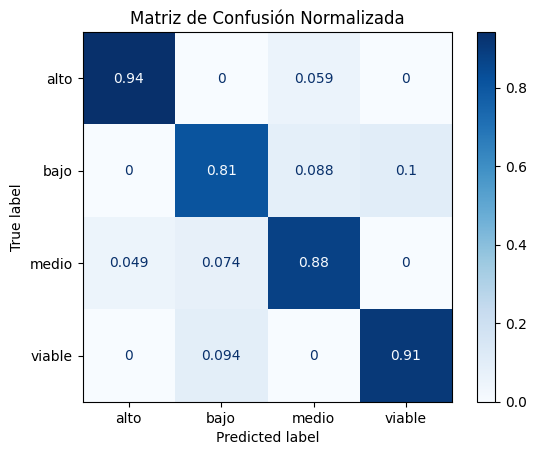

In [86]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# ** Crear la matriz de confusión **
cm = confusion_matrix(y_test, y_pred_best)

# ** Normalizar la matriz de confusión por cada fila (es decir, por la suma de cada clase verdadera) **
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ** Mostrar la matriz de confusión normalizada utilizando ConfusionMatrixDisplay **
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión Normalizada')
plt.show()


## Curva ROC y AUC

La curva ROC (Receiver Operating Characteristic) y el AUC (Area Under the Curve) son herramientas útiles cuando trabajas con problemas de clasificación, como es tu caso. Estas curvas permiten evaluar la capacidad del modelo para distinguir entre las diferentes clases (si hay o no "contaminación metálica").

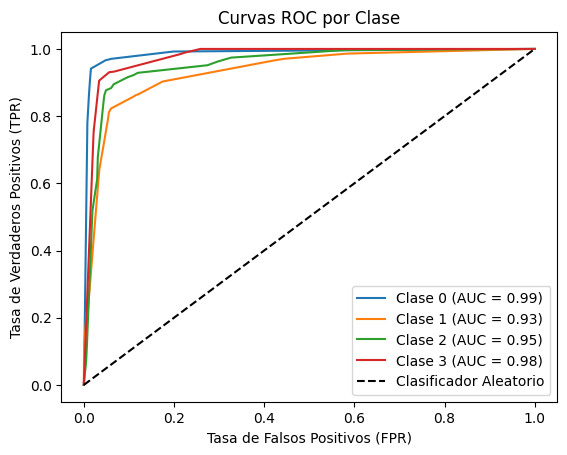

In [87]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# ** Obtener las probabilidades de predicción del conjunto de prueba **
y_score = best_clf.predict_proba(X_test)

# ** Verificar cuántas clases tiene la variable objetivo **
n_classes = len(np.unique(y_train))  # Número de clases en y_train

# ** Binarizar las etiquetas para aplicar el método One-vs-Rest si es multiclase **
y_test_bin = label_binarize(y_test, classes=[i for i in range(n_classes)])

# ** Crear una figura para las curvas ROC **
plt.figure()

# Para cada clase, calculamos la curva ROC y el AUC
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc:.2f})')

# ** Agregar línea de referencia (clasificador aleatorio) **
plt.plot([0, 1], [0, 1], 'k--', label="Clasificador Aleatorio")

# ** Etiquetas y título de la gráfica **
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()


## Validación cruzada

La validación cruzada es una técnica que nos permite evaluar el rendimiento de un modelo en diferentes particiones del conjunto de datos para asegurarnos de que el modelo no depende demasiado de una sola división entre entrenamiento y validación. Esto mejora la robustez de la evaluación del modelo.

Ya que estamos usando un árbol de decisión con GridSearchCV, ejecutamos una validación cruzada con el mejor modelo (best_clf). Usamos cross_val_score para realizar la validación cruzada y calcular una métrica promedio de precisión.

In [88]:
from sklearn.model_selection import cross_val_score

# ** Realizar validación cruzada con el modelo optimizado **
# En este caso, usaremos 5 particiones (cv=5)
cv_scores = cross_val_score(best_clf, X_train, y_train, cv=5)

# ** Mostrar los resultados de cada partición y el promedio **
print("Precisión en cada pliegue de validación cruzada: ", cv_scores)
print(f"Precisión promedio en validación cruzada: {np.mean(cv_scores):.2f}")


Precisión en cada pliegue de validación cruzada:  [0.85885167 0.86570743 0.85131894 0.88009592 0.89688249]
Precisión promedio en validación cruzada: 0.87


## Aprendizaje
Nos permitirá evaluar cómo el rendimiento del modelo cambia a medida que se aumenta el tamaño del conjunto de entrenamiento. Es útil para detectar problemas de sobreajuste (overfitting) o subajuste (underfitting).

- **Sobreajuste:** Si el modelo tiene un rendimiento excelente en el conjunto de entrenamiento pero pobre en el conjunto de validación, puede ser una señal de sobreajuste.
- **Subajuste:** Si tanto el conjunto de entrenamiento como el de validación tienen un bajo rendimiento, puede significar que el modelo es demasiado simple para capturar la complejidad de los datos.
Implementación e

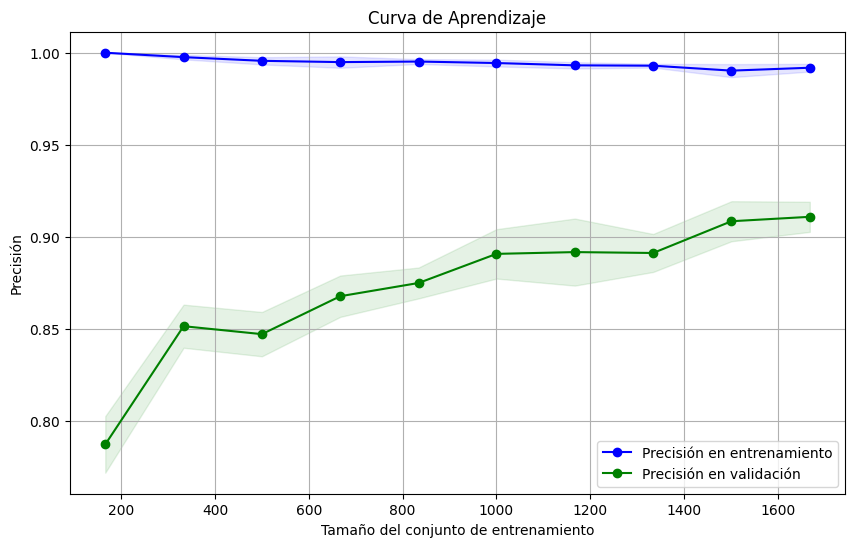

In [92]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# ** Definir el modelo (ya optimizado) **
model = best_clf  # Usamos el mejor modelo encontrado con GridSearchCV

# ** Generar la curva de aprendizaje **
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# ** Calcular la media y desviación estándar para los conjuntos de entrenamiento y validación **
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# ** Graficar la curva de aprendizaje **
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Precisión en entrenamiento")
plt.plot(train_sizes, test_mean, 'o-', color="green", label="Precisión en validación")

# ** Rellenar la desviación estándar como sombra alrededor de las líneas **
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")

# ** Configuración de etiquetas y leyendas **
plt.title('Curva de Aprendizaje')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Precisión')
plt.legend(loc='best')
plt.grid()
plt.show()


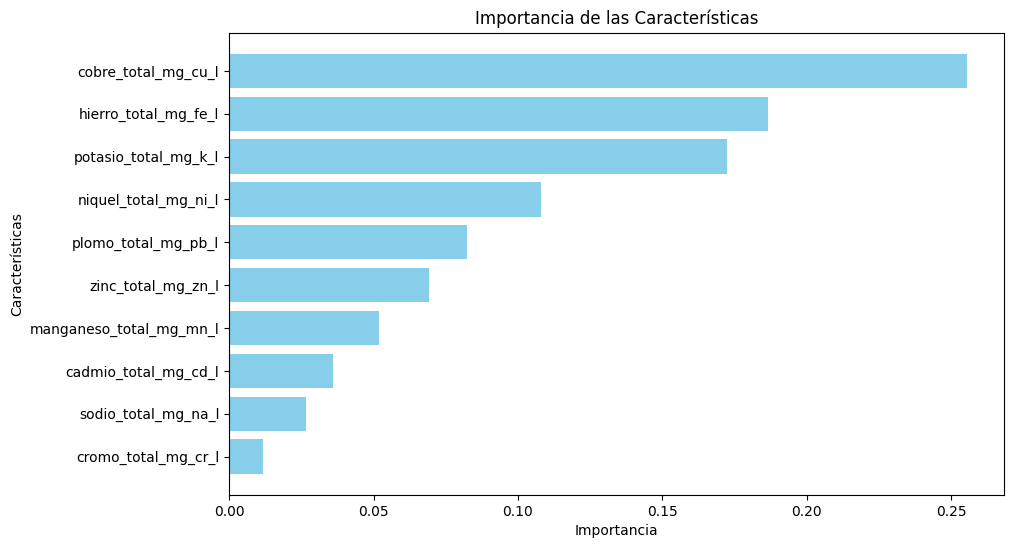

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

# ** Obtener la importancia de las características del modelo optimizado **
importances = best_clf.feature_importances_

# ** Crear un DataFrame para visualizar las características y su importancia **
features_df = pd.DataFrame({
    'Características': FEATURES,  # Tu lista de características
    'Importancia': importances
})

# ** Ordenar las características por su importancia de mayor a menor **
features_df = features_df.sort_values(by='Importancia', ascending=False)

# ** Visualizar las características más importantes en una gráfica de barras **
plt.figure(figsize=(10, 6))
plt.barh(features_df['Características'], features_df['Importancia'], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las Características')
plt.gca().invert_yaxis()  # Invertir el eje y para mostrar la característica más importante en la parte superior
plt.show()
